In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from func import OR,heatplot,misorientation,mat2plot, match,imgshow,calpoint,L2,L1,ipfread
from Class import Exp,Data,Cluster
import sys
import os
import cv2
import pandas as pd
from unet import UNet
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.patches as patches
def create_data(data_list,h0,w0,h,w):
    h,w=50,50;ps=8
    bef,aft,im,im_=data_list
    X=[];Y=[];ind=[];ind_=[]
    while True:
        if X!=[]:
            break
        h0,w0=np.random.randint(ps,im.shape[0]-h-ps+1),np.random.randint(ps,im.shape[1]-w-ps+1)
        ind=[h0,w0]
        #crop
        cp=Data(crop=[bef,h0,w0,h,w])
        exp=Exp(cp,aft)
        p,min_val=match(L2,im[h0:h0+h,w0:w0+w],im_,h0,w0);exp.i,exp.j=p
        ind_=p
#         imgshow(im[h0:h0+h,w0:w0+w])
#         imgshow(exp.mod(im_))
#         print(min_val)
        if min_val>4000:
            continue
        #crop with padding
        cpp=Data(crop=[bef,h0-ps,w0-ps,h+2*ps,w+2*ps]) 
        ret=[]
        for ele in ["Phase","MAD","BC","BS","Bands","Error"]:
            ret.append(cpp.get(ele).reshape(h+2*ps,w+2*ps,1))
        ret.append(cpp.get("orient").reshape(h+2*ps,w+2*ps,-1))
        X=np.concatenate(ret,axis=2).transpose(2,0,1)
        Y=exp.getmatch("Phase",1)!=0
#         print(len(X),len(Y))
    return X,Y,ind,ind_
class dataset(Dataset):
    def __init__(self,bef,aft,im,im_):
        self.bef=bef
        self.aft=aft
        self.im=im
        self.im_=im_
        
    def __getitem__(self,index):
        index=index%(len(self.bef))
        X,Y,ind,ind_=create_data([self.bef[index],self.aft[index],self.im[index],self.im_[index]])
        return torch.tensor(X,dtype=torch.float32),torch.tensor(Y,dtype=torch.long),ind,ind_,index
    def __len__(self):
        return len(self.bef)*2048


In [2]:
def create_dataset(root="data/train/"):
    bef=[]
    aft=[]
    im=[]
    im_=[]
    for date in os.listdir(root):
        path=root+date+"/before/"
        path_=root+date+"/after/"
        bef.append(Data(path));aft.append(Data(path_))
        im.append(ipfread(path)/255.);im_.append(ipfread(path_)/255.)
    return dataset(bef,aft,im,im_)
# train=dataset(bef,aft,im,im_)


In [3]:
train=create_dataset("data/train/")
# test=create_dataset("data/test/")

In [41]:
index = 0
phase=1-train.aft[index].data["Phase"]
# np.save("sample.npy",phase)
# phase=1-np.load("sample.npy")
# plt.imshow(train.aft[0].data["Phase"],cmap="gray")

In [42]:
cmap=np.zeros([phase.shape[0],phase.shape[1]]).astype("int")
cluster=dict()
ind = 1
for i in range(phase.shape[0]):
    for j in range(phase.shape[1]):
        if phase[i,j]==1:
            if j>0 and phase[i,j-1]==1:
                cmap[i,j]=cmap[i,j-1]
                cluster[cmap[i,j]].add(i,j)
                if i>0 and phase[i-1,j]==1 and cmap[i,j]!=cmap[i-1,j]:
                    cluster[cmap[i,j]].addn(cmap[i-1,j])
                    cluster[cmap[i-1,j]].addn(cmap[i,j])                    
            elif i>0 and phase[i-1,j]==1:
                cmap[i,j]=cmap[i-1,j]
                cluster[cmap[i,j]].add(i,j)
            else:
                cmap[i,j]=ind
                cluster[ind]=Cluster(ind,i,j)
                ind+=1   

In [43]:
for key in range(1,ind):
    if key in cluster:
        for neigh in cluster[key].neigh.copy():
            cluster[key].merge(neigh,cluster)
crack=[]
phase_aft=np.zeros([phase.shape[0],phase.shape[1]])
for key in range(1,ind):
    if key in cluster:
        if cluster[key].num>200:
            for (i,j) in cluster[key].pixels:
                phase_aft[i,j]=1
            crack.append(key)
crack_rec = []
for id in crack:
    sample=np.array(list(cluster[id].pixels))
    top,left=np.min(sample,axis=0)
    bot,right=np.max(sample,axis=0)
    crack_rec.append([top,bot,left,right])

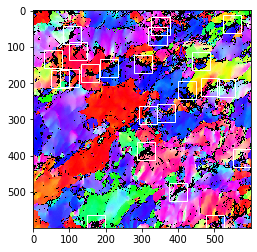

In [44]:
h=w=50
im = train.im[index]
im_ = train.im_[index]
fig,ax = plt.subplots(1)
ax.imshow(im_[:,:,6:])
corner_d = []
corner_b = []
# w0,h0,w,h
for i in range(len(crack_rec)):
    top,bot,left,right = crack_rec[i]
    top = (top+bot)//2-25
    left = (left+right)//2-25
    
    try:
        p,min_val=match(L2,im_[top:top+h,left:left+w],im,top,left)
        if min_val<5000 and p[0]>0 and p[1]>0 and p[0]+h<im.shape[0] and p[1]+w<im.shape[1]:
            rect = patches.Rectangle((left,top),50,50,linewidth=1,edgecolor='w',facecolor='none')
            ax.add_patch(rect)
            corner_d.append([top,left])
            corner_b.append(p)
    except:
        pass
plt.savefig("train%dd.png"%(index),dpi=600)
plt.show()


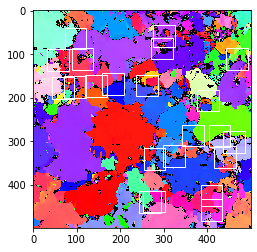

In [45]:
fig,ax = plt.subplots(1)
ax.imshow(train.im[index][:,:,6:])
# w0,h0,w,h
for i in range(len(corner_b)):
    top,left = corner_b[i]
    rect = patches.Rectangle((left,top),50,50,linewidth=1,edgecolor='w',facecolor='none')
    ax.add_patch(rect)
plt.savefig("train%db.png"%(index),dpi=600)
plt.show()

In [46]:
np.save("train_corner_%d.npy"%(index),[corner_b,corner_d])
# np.load("train0_corner_2.npy")

In [40]:
np.load("train0_corner_0.npy")

array([[[ 86, 443],
        [ 34, 276],
        [ 39,  72],
        [ 62, 271],
        [ 87,  88],
        [182, 376],
        [ 88,  31],
        [147, 236],
        [144, 158],
        [149, 119],
        [153,  44],
        [150,  71],
        [264, 403],
        [262, 342],
        [277, 436],
        [309, 299],
        [316, 254],
        [414, 253],
        [311, 415],
        [400, 385],
        [415, 244],
        [434, 385]],

       [[ 13, 523],
        [ 17, 326],
        [ 43,  81],
        [ 46, 318],
        [ 87,  98],
        [115, 438],
        [109,  30],
        [123, 277],
        [133, 184],
        [147, 132],
        [164,  48],
        [161,  75],
        [185, 462],
        [195, 399],
        [189, 507],
        [258, 341],
        [263, 292],
        [363, 287],
        [382, 551],
        [476, 375],
        [563, 147],
        [563, 477]]])